In [1]:
name = '2016-10-14-loading-netcdf-datasets'
title = 'Loading NetCDF datasets'
tags = 'netcdf, io'
author = 'Denis Sergeev'

In [2]:
from nb_tools import connect_notebook_to_post
from IPython.core.display import HTML, Image

html = connect_notebook_to_post(name, title, tags, author)

Continuing the previous week's topic, today we went through the basics of loading netCDF datasets.

In this notebook we explore a netCDF file from the Atlantic Real-Time Ocean Forecast System (downloaded from the Unidata Python Workshop's [GitHub repository](https://unidata.github.io/unidata-python-workshop/). The filename is [rtofs_glo_3dz_f006_6hrly_reg3.nc](https://github.com/Unidata/tds-python-workshop/blob/master/data/rtofs_glo_3dz_f006_6hrly_reg3.nc).

In [3]:
import os
path_to_file = os.path.join(os.path.pardir, 'data', 'rtofs_glo_3dz_f006_6hrly_reg3.nc')
print(path_to_file)

../data/rtofs_glo_3dz_f006_6hrly_reg3.nc


First, let's load essential modules

In [4]:
from __future__ import division, print_function
import netCDF4 as nc
import numpy as np

## Create a netCDF4.Dataset object from file

In [5]:
f = nc.Dataset(path_to_file)
print(f) 

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.0
    title: HYCOM ATLb2.00
    institution: National Centers for Environmental Prediction
    source: HYCOM archive file
    experiment: 90.9
    history: archv2ncdf3z
    dimensions(sizes): MT(1), Y(850), X(712), Depth(10)
    variables(dimensions): float64 MT(MT), float64 Date(MT), float32 Depth(Depth), int32 Y(Y), int32 X(X), float32 Latitude(Y,X), float32 Longitude(Y,X), float32 u(MT,Depth,Y,X), float32 v(MT,Depth,Y,X), float32 temperature(MT,Depth,Y,X), float32 salinity(MT,Depth,Y,X)
    groups: 



So what have we got here?

- **`f`** is a `Dataset` object, representing an open netCDF file.
- printing the object gives you summary information, similar to *`ncdump -h`*.

You can also get a list of global attributes:

In [6]:
f.ncattrs()

['Conventions', 'title', 'institution', 'source', 'experiment', 'history']

## List the Dimensions

- All variables in a netCDF file have an associated shape, specified by a list of dimensions.
- Let's list all the dimensions in this netCDF file.
- Note that the **`MT`** dimension is special (*`unlimited`*), which means it can be appended to.

In [7]:
for d in f.dimensions.items():
    print(d)

('MT', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'MT', size = 1
)
('Y', <class 'netCDF4._netCDF4.Dimension'>: name = 'Y', size = 850
)
('X', <class 'netCDF4._netCDF4.Dimension'>: name = 'X', size = 712
)
('Depth', <class 'netCDF4._netCDF4.Dimension'>: name = 'Depth', size = 10
)


## Access a netCDF variable
- variable objects stored by name in **`variables`** dict.
- print the variable yields summary info (including all the attributes).
- no actual data read yet (just have a reference to the variable object with metadata).

In [8]:
type(f.variables)

collections.OrderedDict

In [9]:
print(f.variables.keys()) # get all variable names

# or like this: [*f.variables.keys()]

odict_keys(['MT', 'Date', 'Depth', 'Y', 'X', 'Latitude', 'Longitude', 'u', 'v', 'temperature', 'salinity'])


### Access salinity variable

In [10]:
temp_c = f.get_variables_by_attributes(units='degC')[0]
sal = f.variables['salinity']

In [11]:
print(sal)

<class 'netCDF4._netCDF4.Variable'>
float32 salinity(MT, Depth, Y, X)
    coordinates: Longitude Latitude Date
    standard_name: sea_water_salinity
    units: psu
    _FillValue: 1.26765e+30
    valid_range: [ 11.61832619  35.04695129]
    long_name:  salinity [90.9H]
unlimited dimensions: MT
current shape = (1, 10, 850, 712)
filling on


In [12]:
sal.dimensions, sal.shape

(('MT', 'Depth', 'Y', 'X'), (1, 10, 850, 712))

### Each dimension typically has a variable associated with it (called a *coordinate* variable).
- *Coordinate variables* are 1D variables that have the same name as dimensions.
- Coordinate variables and *auxiliary coordinate variables* (named by the *coordinates* attribute) locate values in time and space.

In [13]:
mt = f.variables['MT']
depth = f.variables['Depth']
x, y = f.variables['X'], f.variables['Y']
print(mt)
print(x)

<class 'netCDF4._netCDF4.Variable'>
float64 MT(MT)
    long_name: time
    units: days since 1900-12-31 00:00:00
    calendar: standard
    axis: T
unlimited dimensions: MT
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
int32 X(X)
    point_spacing: even
    axis: X
unlimited dimensions: 
current shape = (712,)
filling on, default _FillValue of -2147483647 used



## Accessing data from a netCDF variable object

- netCDF variables objects behave much like numpy arrays.
- slicing a netCDF variable object returns a numpy array with the data.
- Only 1-d boolean arrays and integer sequences are allowed, and these indices work independently along each dimension (similar to the way vector subscripts work in fortran).
- Otherwise you get `IndexError: Index cannot be multidimensional` (?).

## What region this dataset refers to?

To plot it, we need the auxilary coordinate variables, `Latitude` and `Longitude` that define the 'real' data coordinates.

In [14]:
lat = f.variables['Latitude']
lon = f.variables['Longitude']
print(lat)

<class 'netCDF4._netCDF4.Variable'>
float32 Latitude(Y, X)
    standard_name: latitude
    units: degrees_north
unlimited dimensions: 
current shape = (850, 712)
filling on, default _FillValue of 9.969209968386869e+36 used



In [15]:
# extract lat/lon values (in degrees) to numpy arrays
latvals = lat[:]; lonvals = lon[:] 

In [16]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

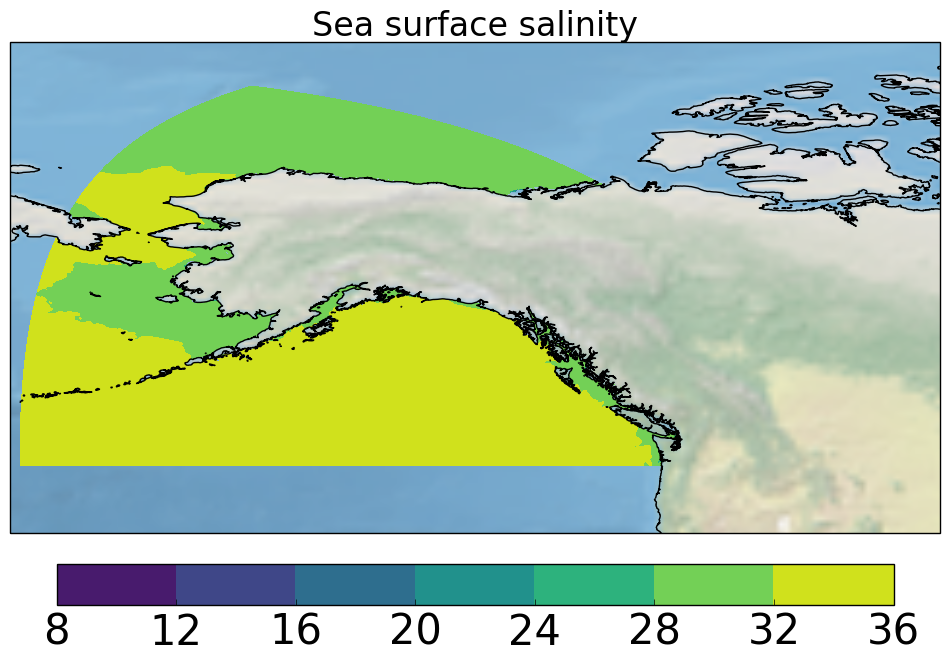

In [17]:
fig, ax = plt.subplots(figsize=(12, 8),
                       subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines('10m')
ax.set_title('Sea surface salinity', fontsize=24)
p = ax.contourf(lonvals, latvals, sal[0, 0, ...], cmap='viridis')
cb = plt.colorbar(p, orientation='horizontal', shrink=0.9, pad=0.05)

ax.set_extent([-180, -100, 40, 80])
ax.stock_img()

# Colorbar ticks fontsize
cb.ax.tick_params(labelsize=30)

## What is the sea surface temperature and salinity near St Lawrence island (63.202533N, 170.650635W)?

- The `X` and `Y` dimensions don't look like longitudes and latitudes
- Use the auxilary coordinate variables named in the `coordinates` variable attribute, `Latitude` and `Longitude`

In [18]:
def getclosest_ij(lats, lons, latpt, lonpt):
    """
    A function to find indices of the point closest
    (in squared distance) to return the given lat/lon value."""
    # find squared distance of every point on grid
    dist_sq = (lats - latpt)**2 + (lons - lonpt)**2  
    # 1D index of minimum dist_sq element
    minindex_flattened = dist_sq.argmin()    
    # Get 2D index for latvals and lonvals arrays from 1D index
    return np.unravel_index(minindex_flattened, lats.shape)

In [19]:
pnt_lat, pnt_lon = (63.202533, -170.650635)

In [20]:
iy, ix = getclosest_ij(latvals, lonvals, pnt_lat, pnt_lon)

In [21]:
# Read values out of the netCDF file for temperature and salinity
print('{value:7.4f} {units}'.format(value=temp_c[0, 0, iy, ix], units=temp_c.units))
print('{value:7.4f} {units}'.format(value=sal[0, 0, iy, ix], units=sal.units))

-1.1020 degC
32.0337 psu


## Simple multi-file aggregation

What if you have a bunch of netcdf files, each with data for a different year, and you want to access all the data as if it were in one file?

Load the files

In [22]:
files_wcard = os.path.join(os.path.pardir, 'data', 'uwnd*nc')
print(files_wcard)

../data/uwnd*nc


In [23]:
mf = nc.MFDataset(files_wcard)

Check time span

In [24]:
times = mf.variables['time']
dates = nc.num2date(times[:], times.units)
print('starting date = {}'.format(dates[0]))
print('  ending date = {}'.format(dates[-1]))

starting date = 1979-01-01 00:00:00
  ending date = 1989-12-31 00:00:00


In [25]:
u = mf.variables['uwnd']
print('u dimensions = {},\nu shape      = {}'.format(u.dimensions, u.shape))

u dimensions = ('time', 'level', 'lat', 'lon'),
u shape      = (4018, 17, 73, 144)


## References

This notebook is build upon the great materials of the [Unidata Python Workshop](https://unidata.github.io/unidata-python-workshop/):
  * https://github.com/Unidata/unidata-python-workshop/blob/master/notebooks/reading_netCDF.ipynb

In [26]:
HTML(html)